In [1]:
import xsimlab as xs
import math


In [2]:
a,b = (10,20)
a

10

In [3]:
@xs.process
class Biomass:
    B_vars = xs.group('biomass')
    dB = xs.variable(intent='inout',default=0)
    B = xs.variable(intent='inout',default=1)
    out_B = xs.variable(intent='out')
    
    #we can actually safely use run_step because of the cycle ordering?
    @xs.runtime(args='step')
    def run_step(self, n):
#         print("Biomass calculating: ")
        self.dB = sum(self.B_vars)
        self.B += self.dB
        self.out_B = self.B
        print("Step: ", n," out_B: ", self.out_B)

#jsut some processes to have a longer cycle
@xs.process
class FracInterceptedLight:
    leaf_area = xs.variable(global_name='leaf_area',intent='in')
    intercepted_light = xs.variable(intent='out')
    ext_coeff = xs.variable(default=0.8)
    
    def run_step(self):
#         print("Frac light calculating: ")
        self.intercepted_light = 1-math.exp(-self.ext_coeff*self.leaf_area)

@xs.process
class LeafAreaAnnual:
    leaf_area = xs.global_ref('leaf_area',intent='out')
    prev_dB = xs.foreign(Biomass, 'dB')

    pl = xs.variable(default = 0.002)
    init_leaf_area = xs.variable(default = 0.01)
    
    def initialize(self):
        self.leaf_area = self.init_leaf_area
    
    @xs.runtime(args='step_delta')
    def run_step(self,dt):
#         print("leaf area calculating")
        self.leaf_area += self.pl*self.prev_dB*dt

#the process maxrad also adds to growth
@xs.process
class MaxExtraTerrestrialRadiation:
    maxrad = xs.variable(intent='out')
    
    @xs.runtime(args='step')
    def run_step(self,n):
        self.maxrad = 1+sin(n/math.pi)
    
    
#this process actually adds some to 'biomass' group
@xs.process
class LightLimitedPlantGrowth:
    frac_light = xs.foreign(FracInterceptedLight,"intercepted_light")
    maxrad = xs.foreign(MaxExtraTerrestrialRadiation,'maxrad')
    
    light_efficiency = xs.variable(default=3)
    biomass_growth = xs.variable(intent='out',groups='biomass')
    
    @xs.runtime(args='step_delta')
    def run_step(self,dt):
#         print("growth calcuating")
        self.biomass_growth = self.light_efficiency*self.frac_light*self.maxrad
    
@xs.process
class InitialBiomass:
    initial = xs.variable(default=1)
    biomass = xs.foreign(Biomass,'B',intent='out')
    
    def initialize(self):
        self.biomass = self.initial

@xs.process
class HalveFLight:
    f_light = xs.foreign(FracInterceptedLight,'intercepted_light',intent='inout')
    
    def run_step(self):
        self.f_light = self.f_light/2
        
@xs.process
class BiomassDeath:
    biomass = xs.foreign(Biomass,"B")
    death_rate = xs.variable(default=0.0005)
    biomass_death = xs.variable(intent='out',groups='biomass')
    
    @xs.runtime(args='step_delta')
    def run_step(self,dt):
#         print("death calcualting")
        self.biomass_death = -self.biomass*self.death_rate*dt
        
@xs.process
class OtherClass:
    biomass = xs.foreign(Biomass,"out_B", intent='in')
    somevar = xs.variable(intent='out')
    
    def initialize(self):
        self.somevar = 1
    
    def run_step(self):
        print('otherclass: ', self.biomass)
        self.somevar += self.biomass

In [4]:
model = xs.Model(
    {
        'halve_f_light':HalveFLight,
        'f_light':FracInterceptedLight,
#         'initial':InitialBiomass,
        'maxrad':MaxExtraTerrestrialRadiation,
        'leaf_area':LeafAreaAnnual,
        'growth':LightLimitedPlantGrowth,
        'death':BiomassDeath,
        'biomass':Biomass,
        'otherclass':OtherClass
    },custom_dependencies = {'growth__frac_light':'halve_f_light'}
)

_dep_processes:  {'halve_f_light': {'f_light'}, 'f_light': {'leaf_area'}, 'maxrad': set(), 'leaf_area': set(), 'growth': {'maxrad', 'halve_f_light'}, 'death': set(), 'biomass': {'growth', 'death'}, 'otherclass': {'biomass'}}
_dep_processes dict:  {'halve_f_light': ['f_light'], 'f_light': ['leaf_area'], 'maxrad': [], 'leaf_area': [], 'growth': ['maxrad', 'halve_f_light'], 'death': [], 'biomass': ['growth', 'death'], 'otherclass': ['biomass']}


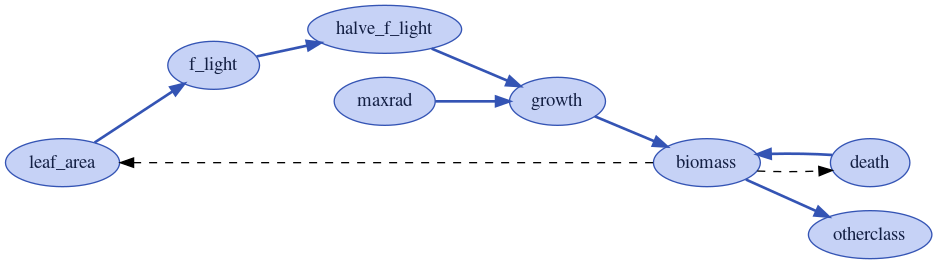

In [5]:
model.visualize()
# model.growth.variables()

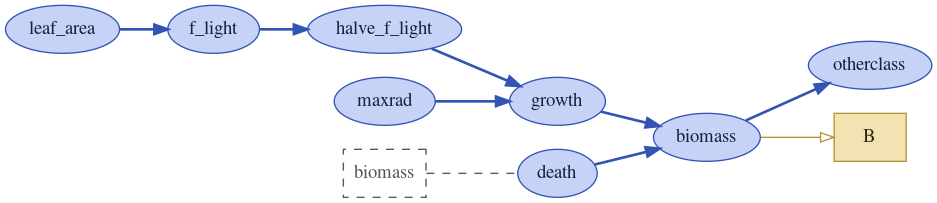

In [6]:
model.visualize(show_only_variable=('biomass','B'))

In [7]:
ds_in = xs.create_setup(model=model,clocks={'clock':range(100)},output_vars={'otherclass__somevar':'clock'})

In [8]:
#plot to verify that it works
ds_in.xsimlab.run(model).otherclass__somevar.plot()

_dep_processes:  {'leaf_area': set(), 'f_light': {'leaf_area'}, 'halve_f_light': {'f_light'}, 'maxrad': set(), 'growth': {'maxrad', 'halve_f_light'}, 'death': set(), 'biomass': {'growth', 'death'}, 'otherclass': {'biomass'}}
_dep_processes dict:  {'leaf_area': [], 'f_light': ['leaf_area'], 'halve_f_light': ['f_light'], 'maxrad': [], 'growth': ['maxrad', 'halve_f_light'], 'death': [], 'biomass': ['growth', 'death'], 'otherclass': ['biomass']}


NameError: name 'sin' is not defined